## Differential expression

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt

sc.settings.verbosity = 2      

In [2]:
sc.settings.set_figure_params(dpi=80)

In [3]:
adata = sc.read_h5ad('./data/results/scanpy_clustered_covid.h5ad')

In [4]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:10])

(5589, 3058)
(5589, 18752)
  (0, 1)	0.90436876
  (0, 6)	0.90436876
  (1, 6)	0.9678403
  (2, 6)	0.5124039


In [5]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### 1. T-test

ranking genes
    finished (0:00:05)


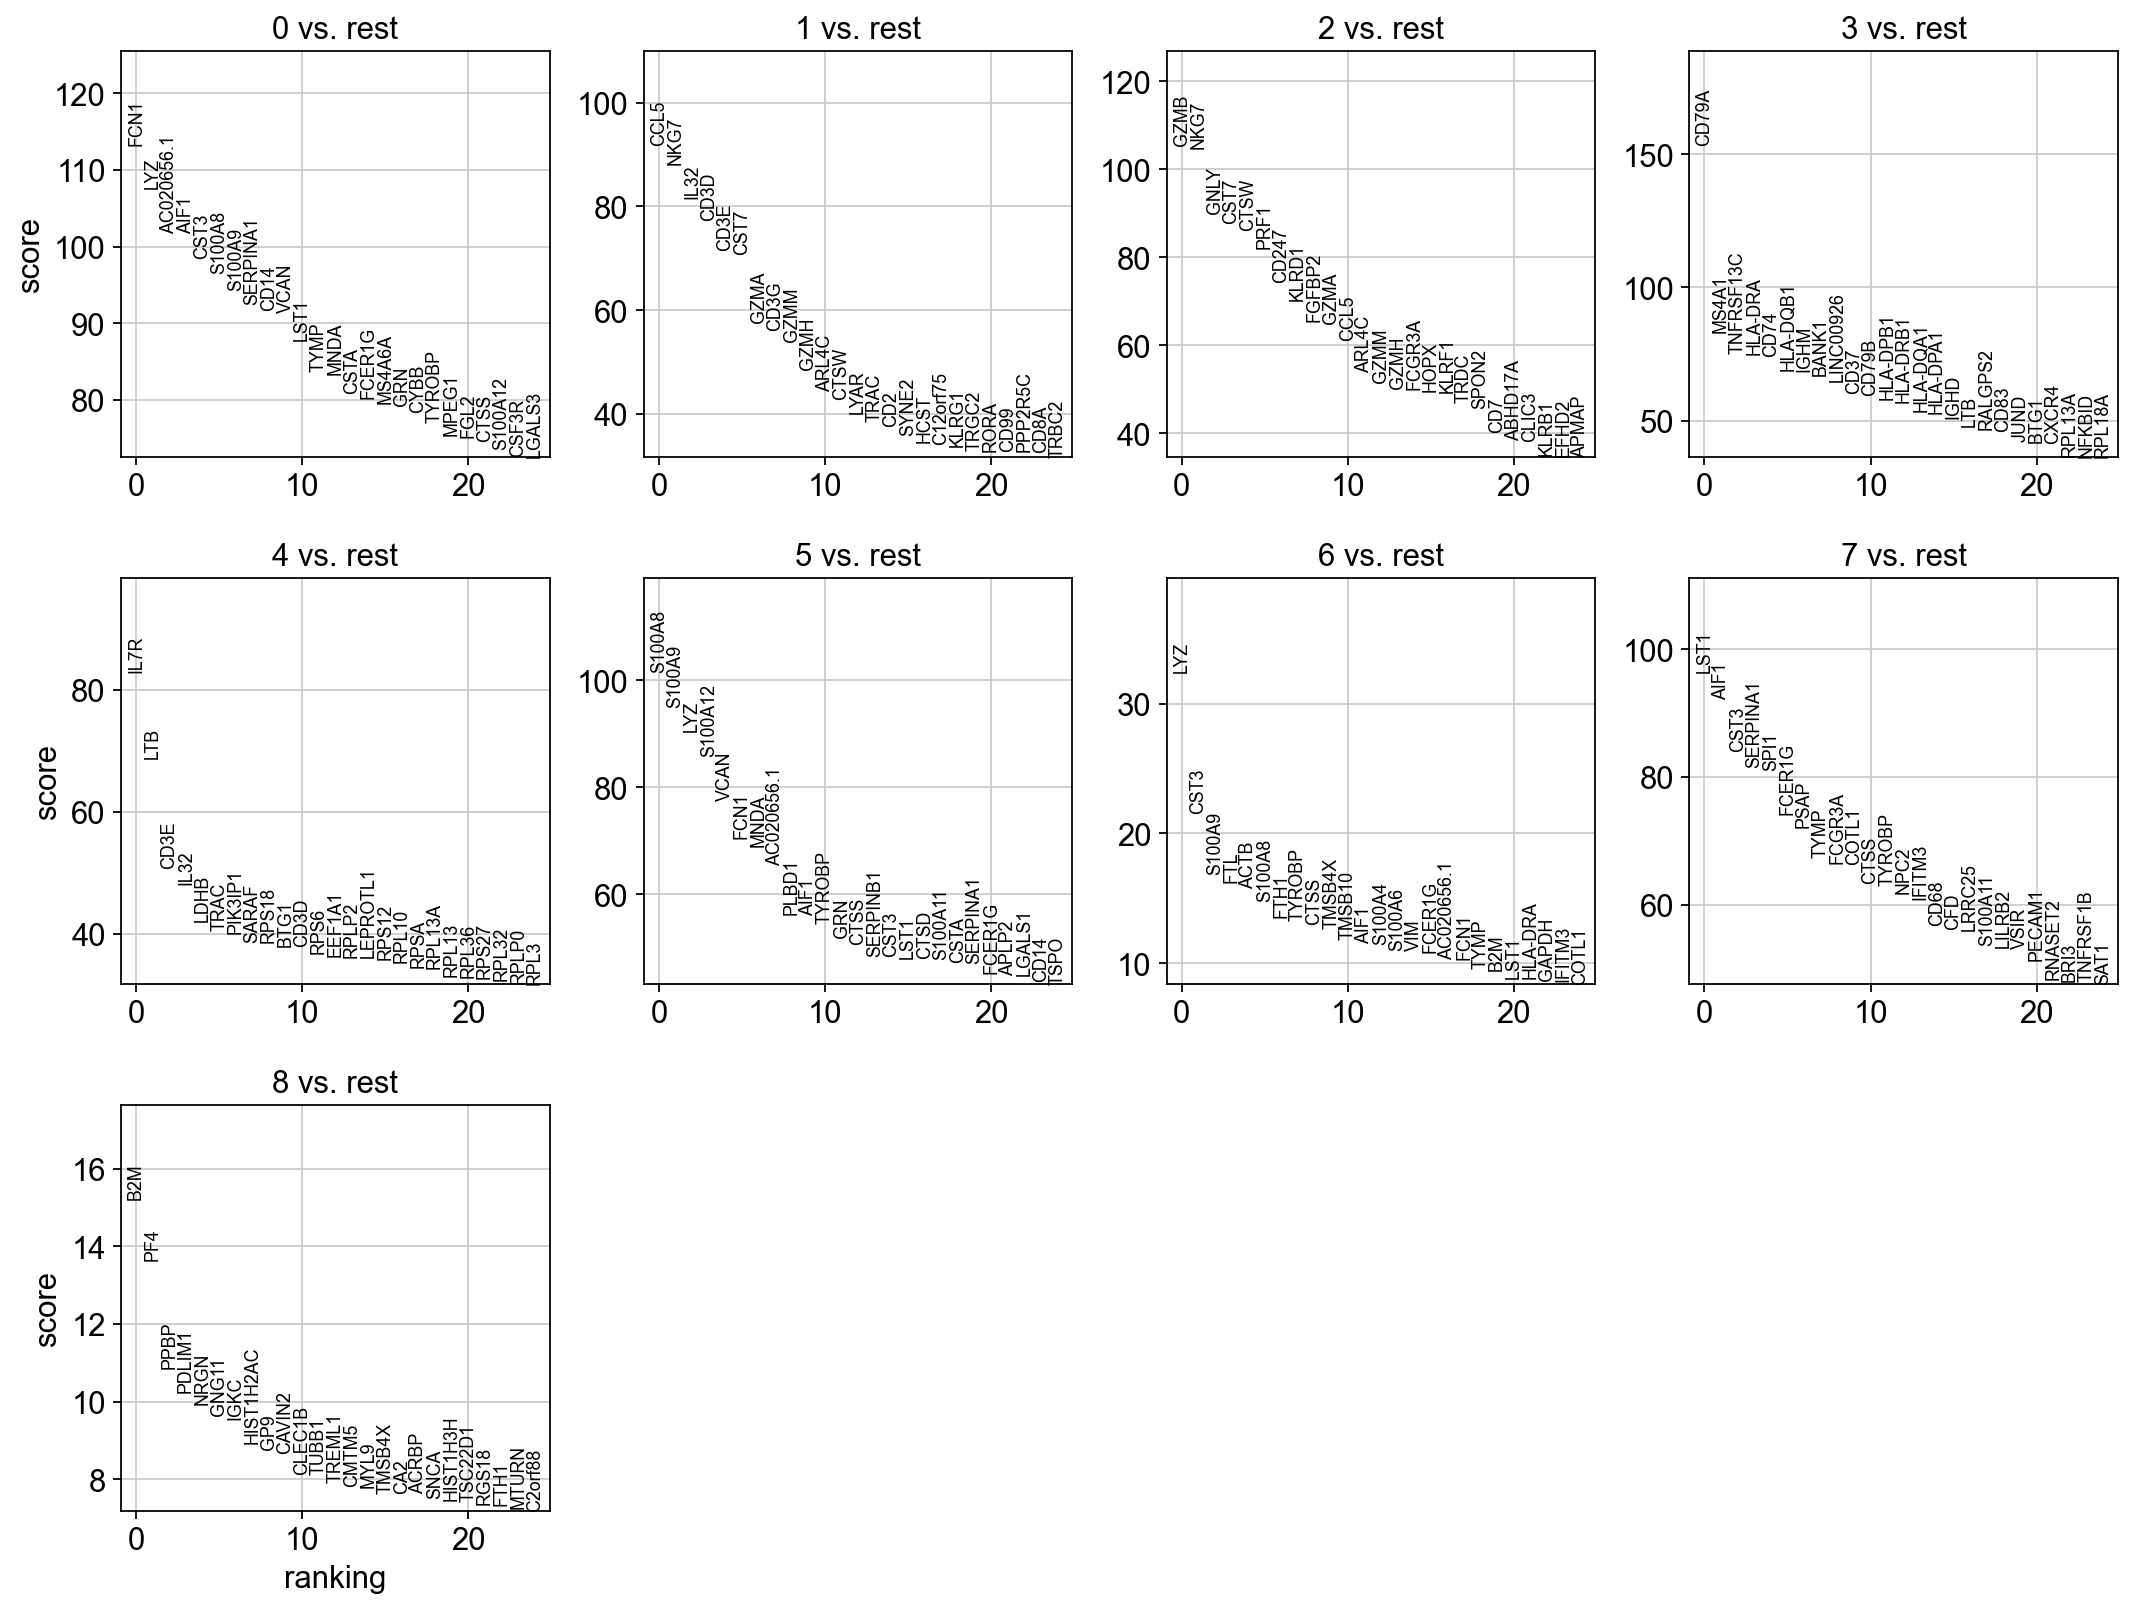

In [6]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

### 2. T-test overestimated_variance

ranking genes
    finished (0:00:02)


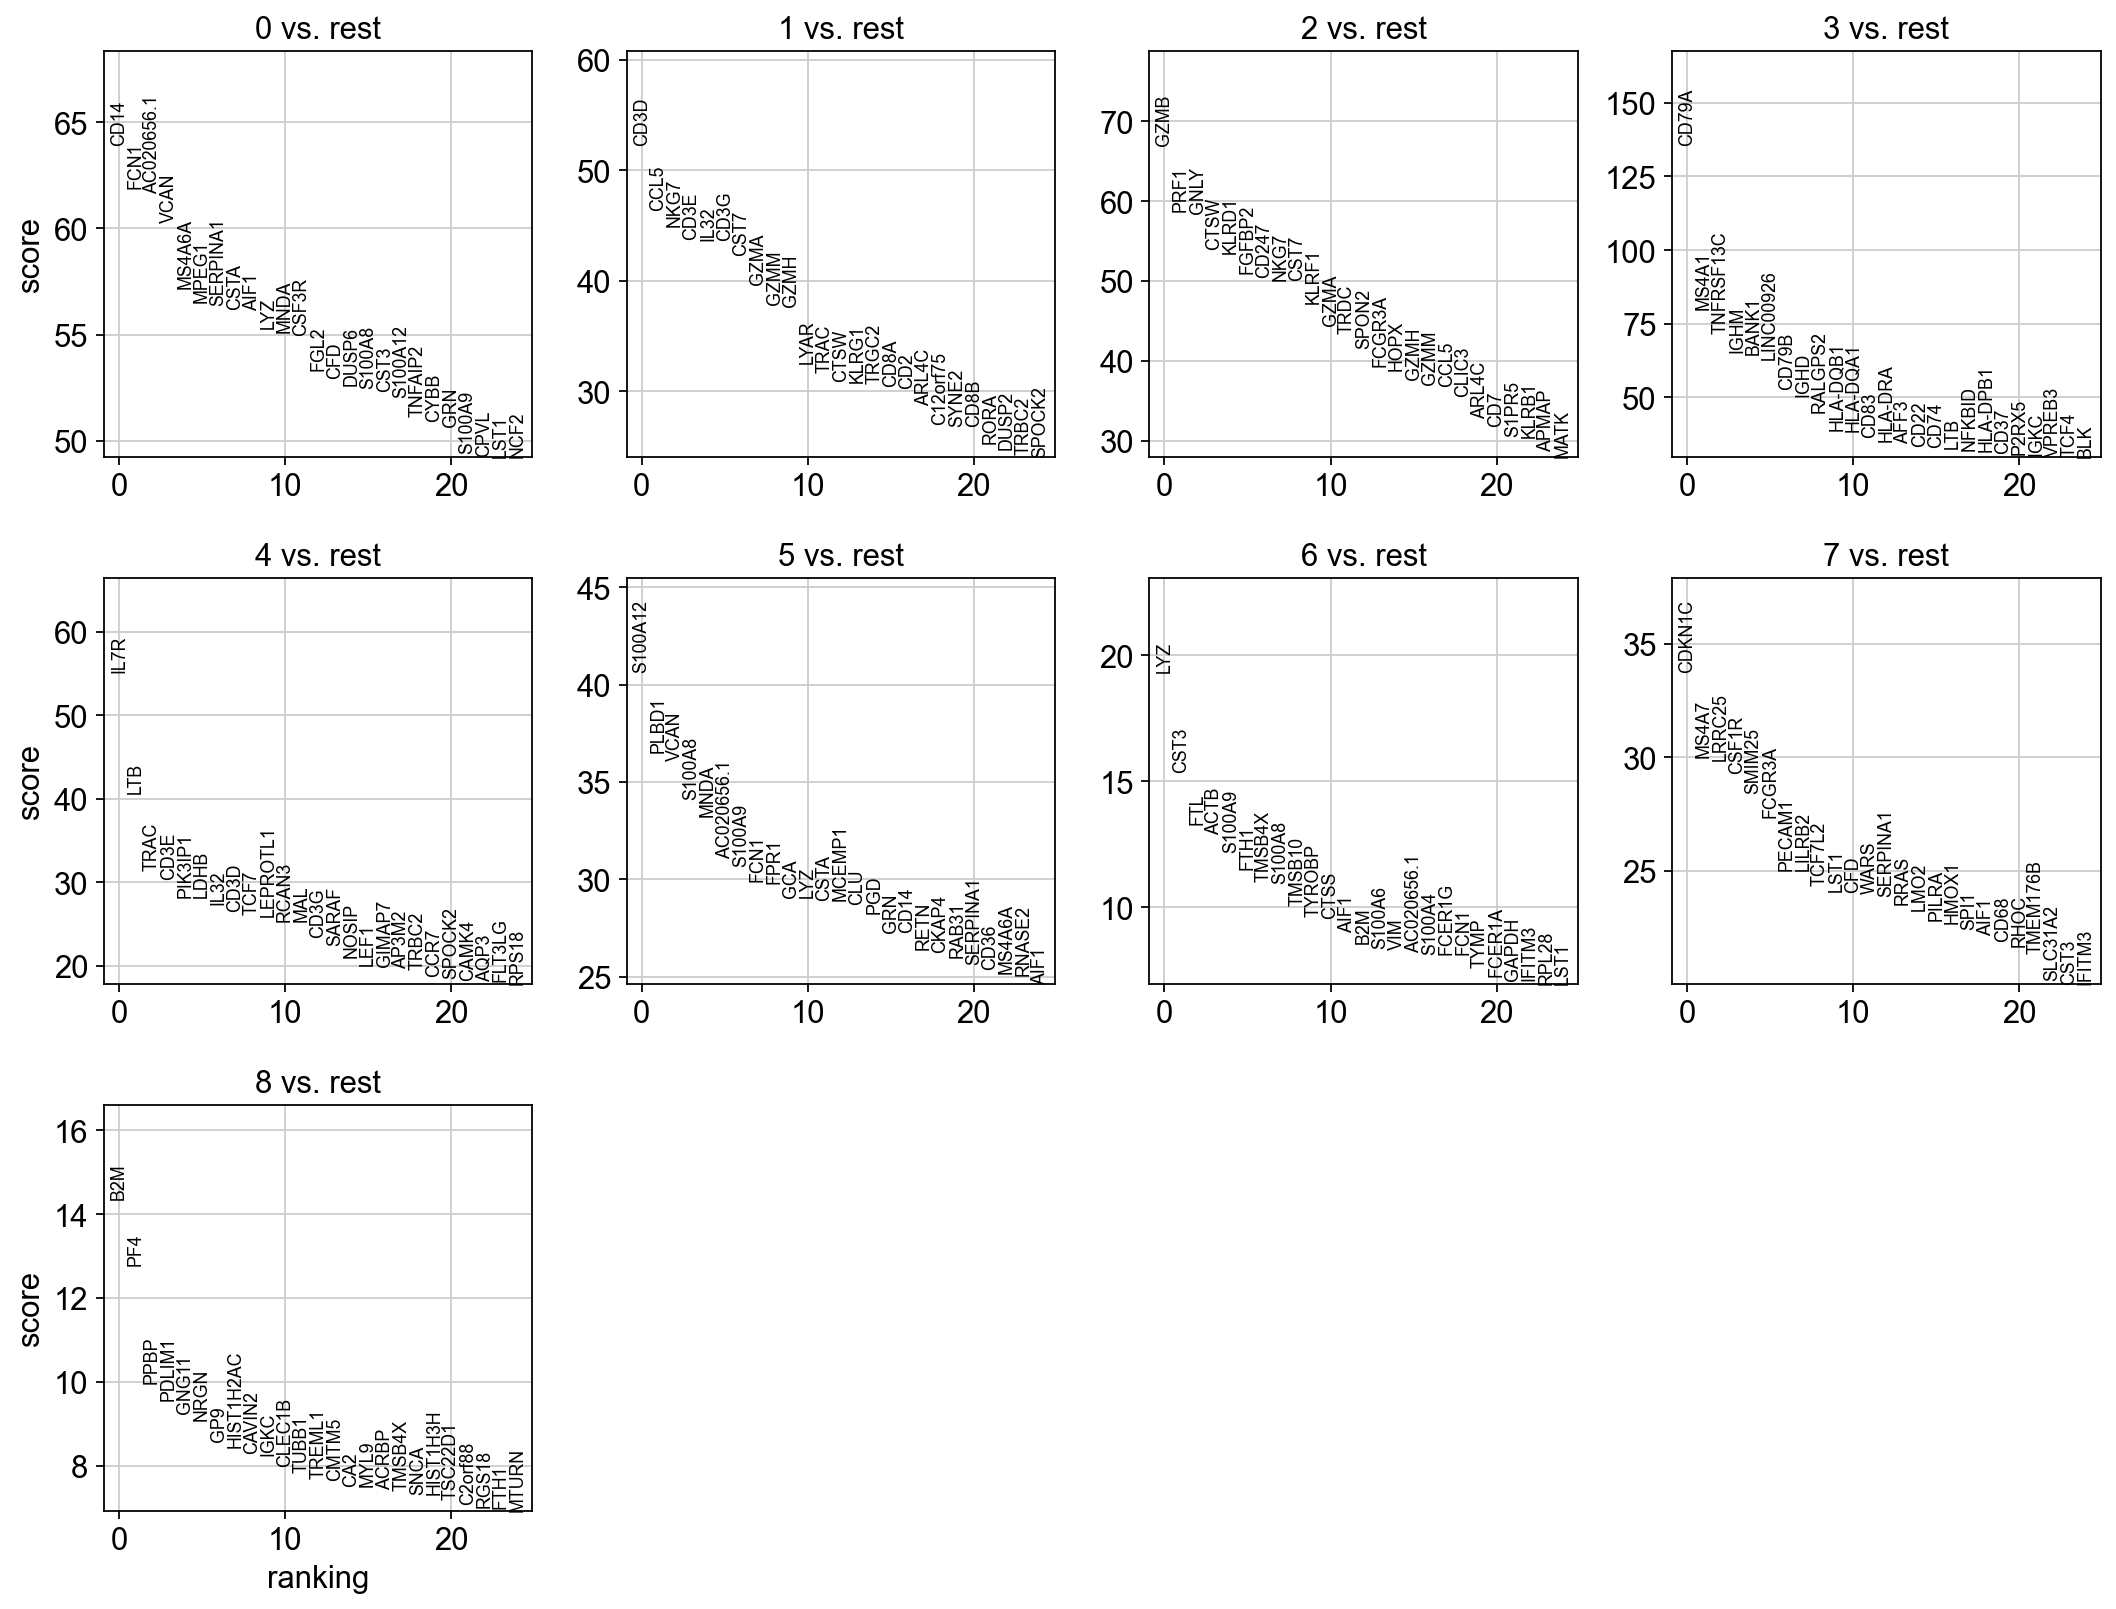

In [10]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key= "t-test_ov")

### 3. Wilcoxon rank-sum

ranking genes
    finished (0:00:25)


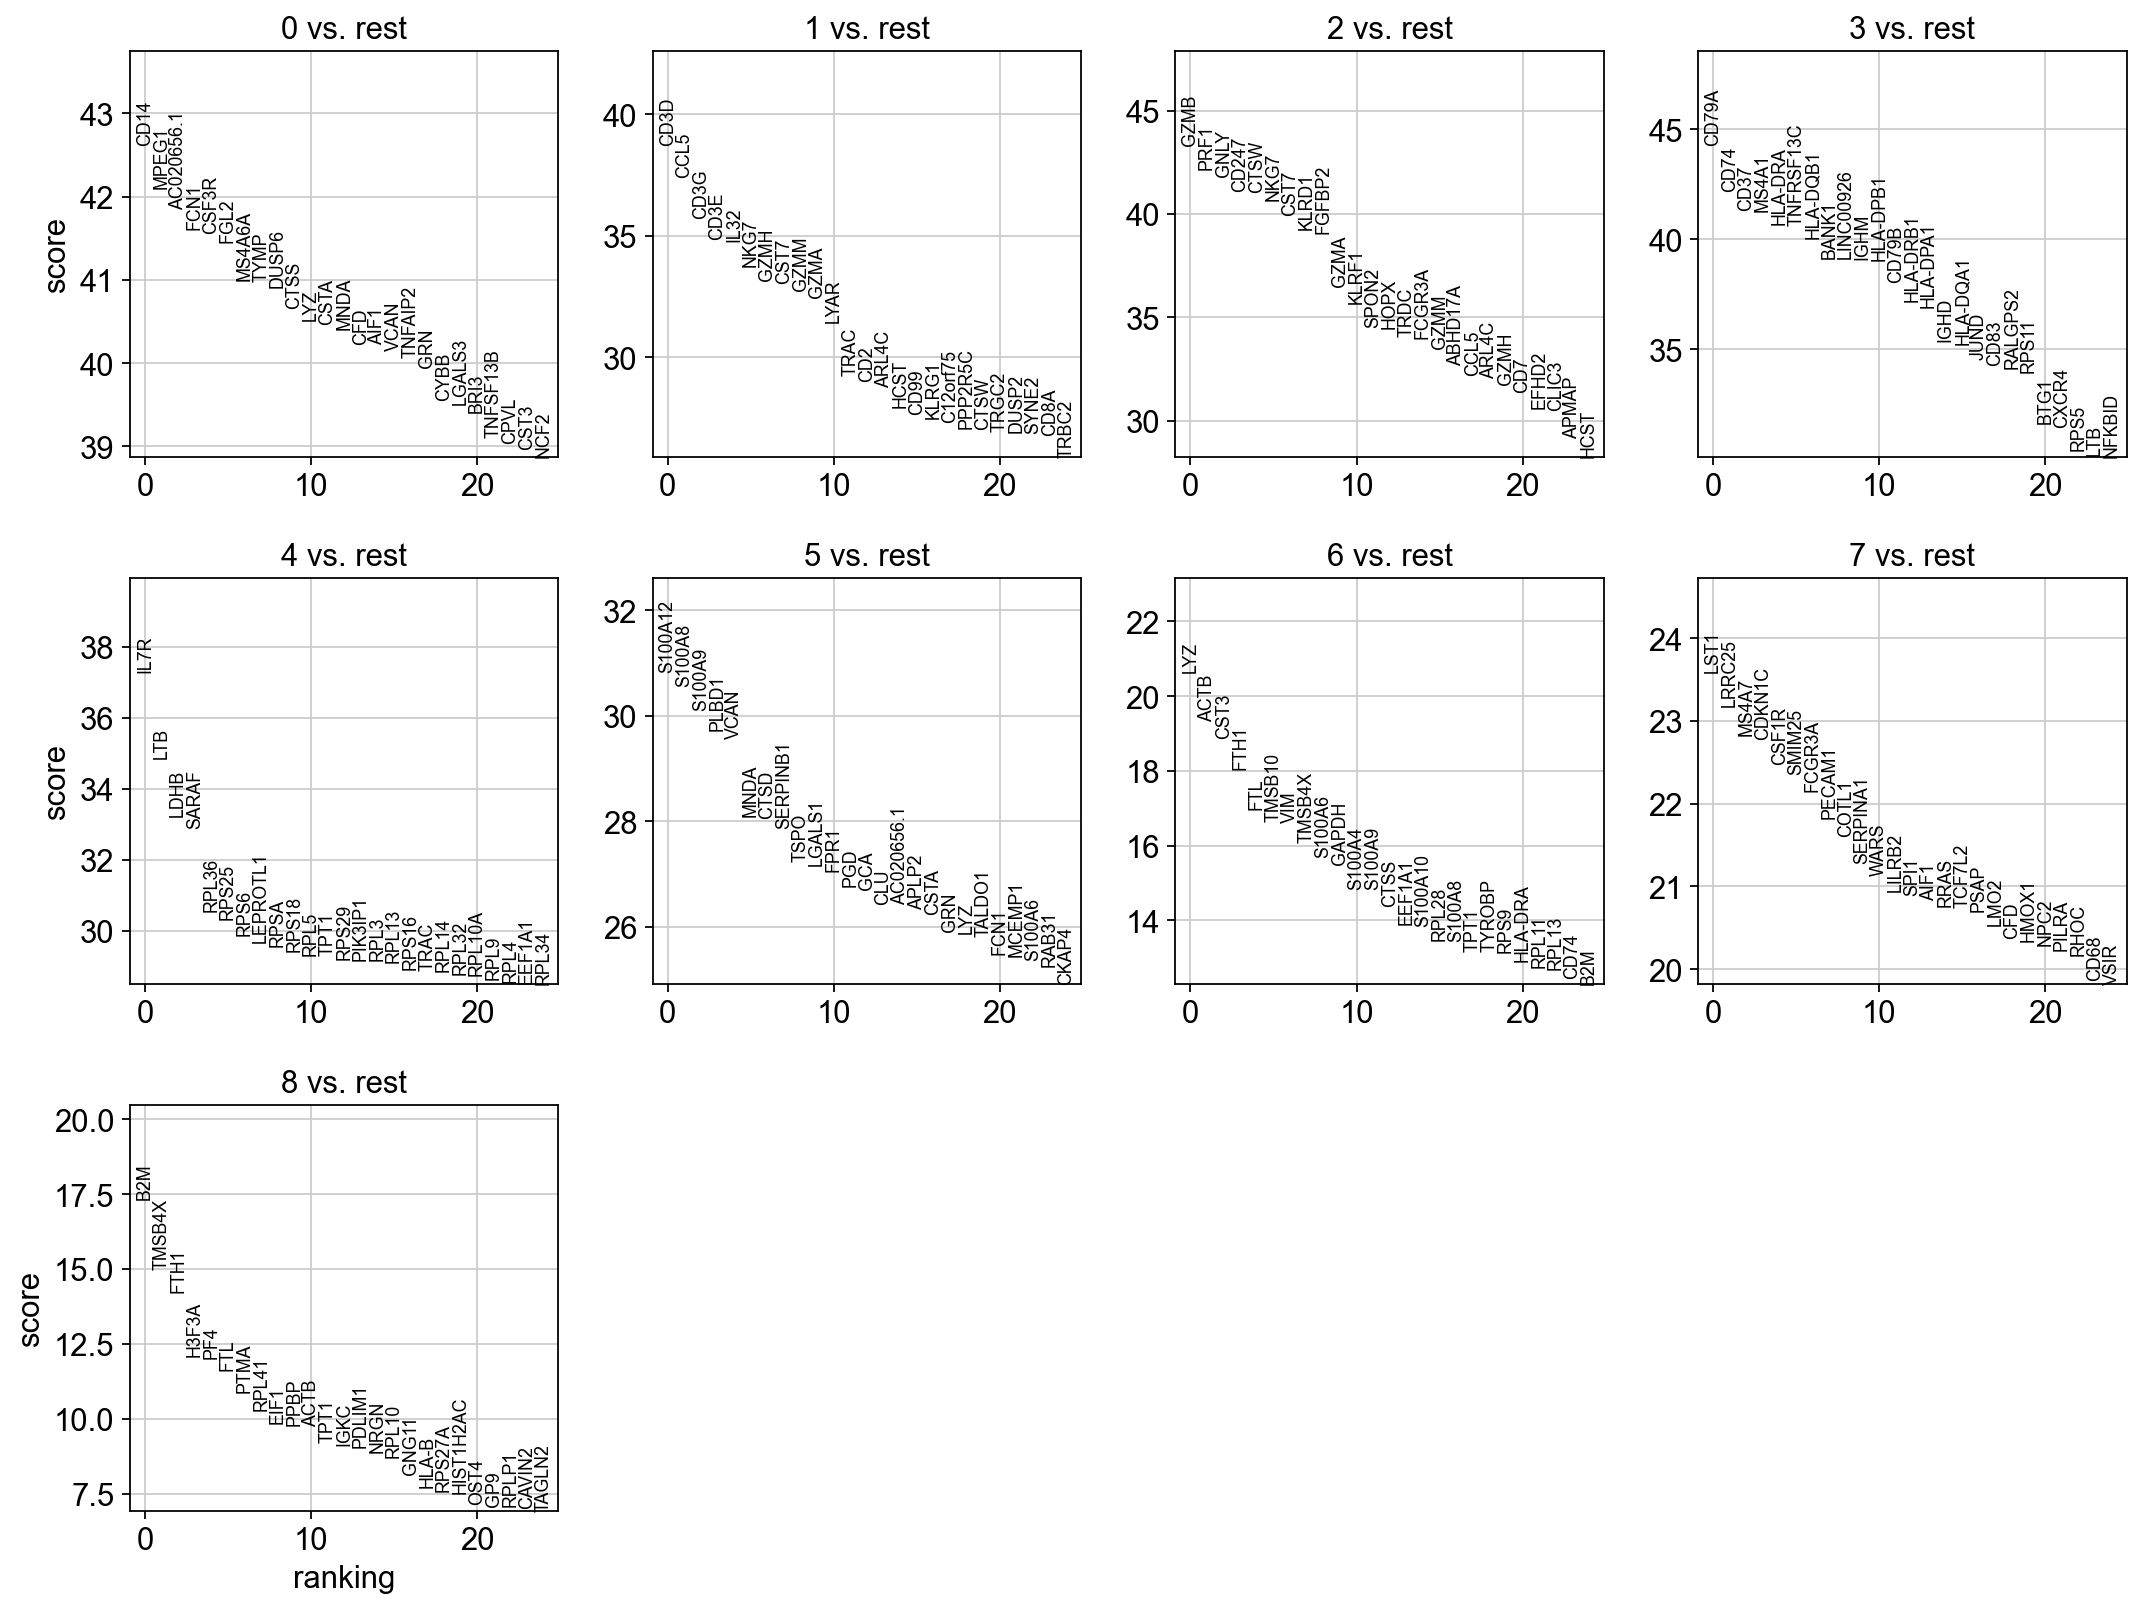

In [12]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='wilcoxon', key_added= "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

### 4  Logistic regression test

ranking genes
    finished (0:00:46)


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


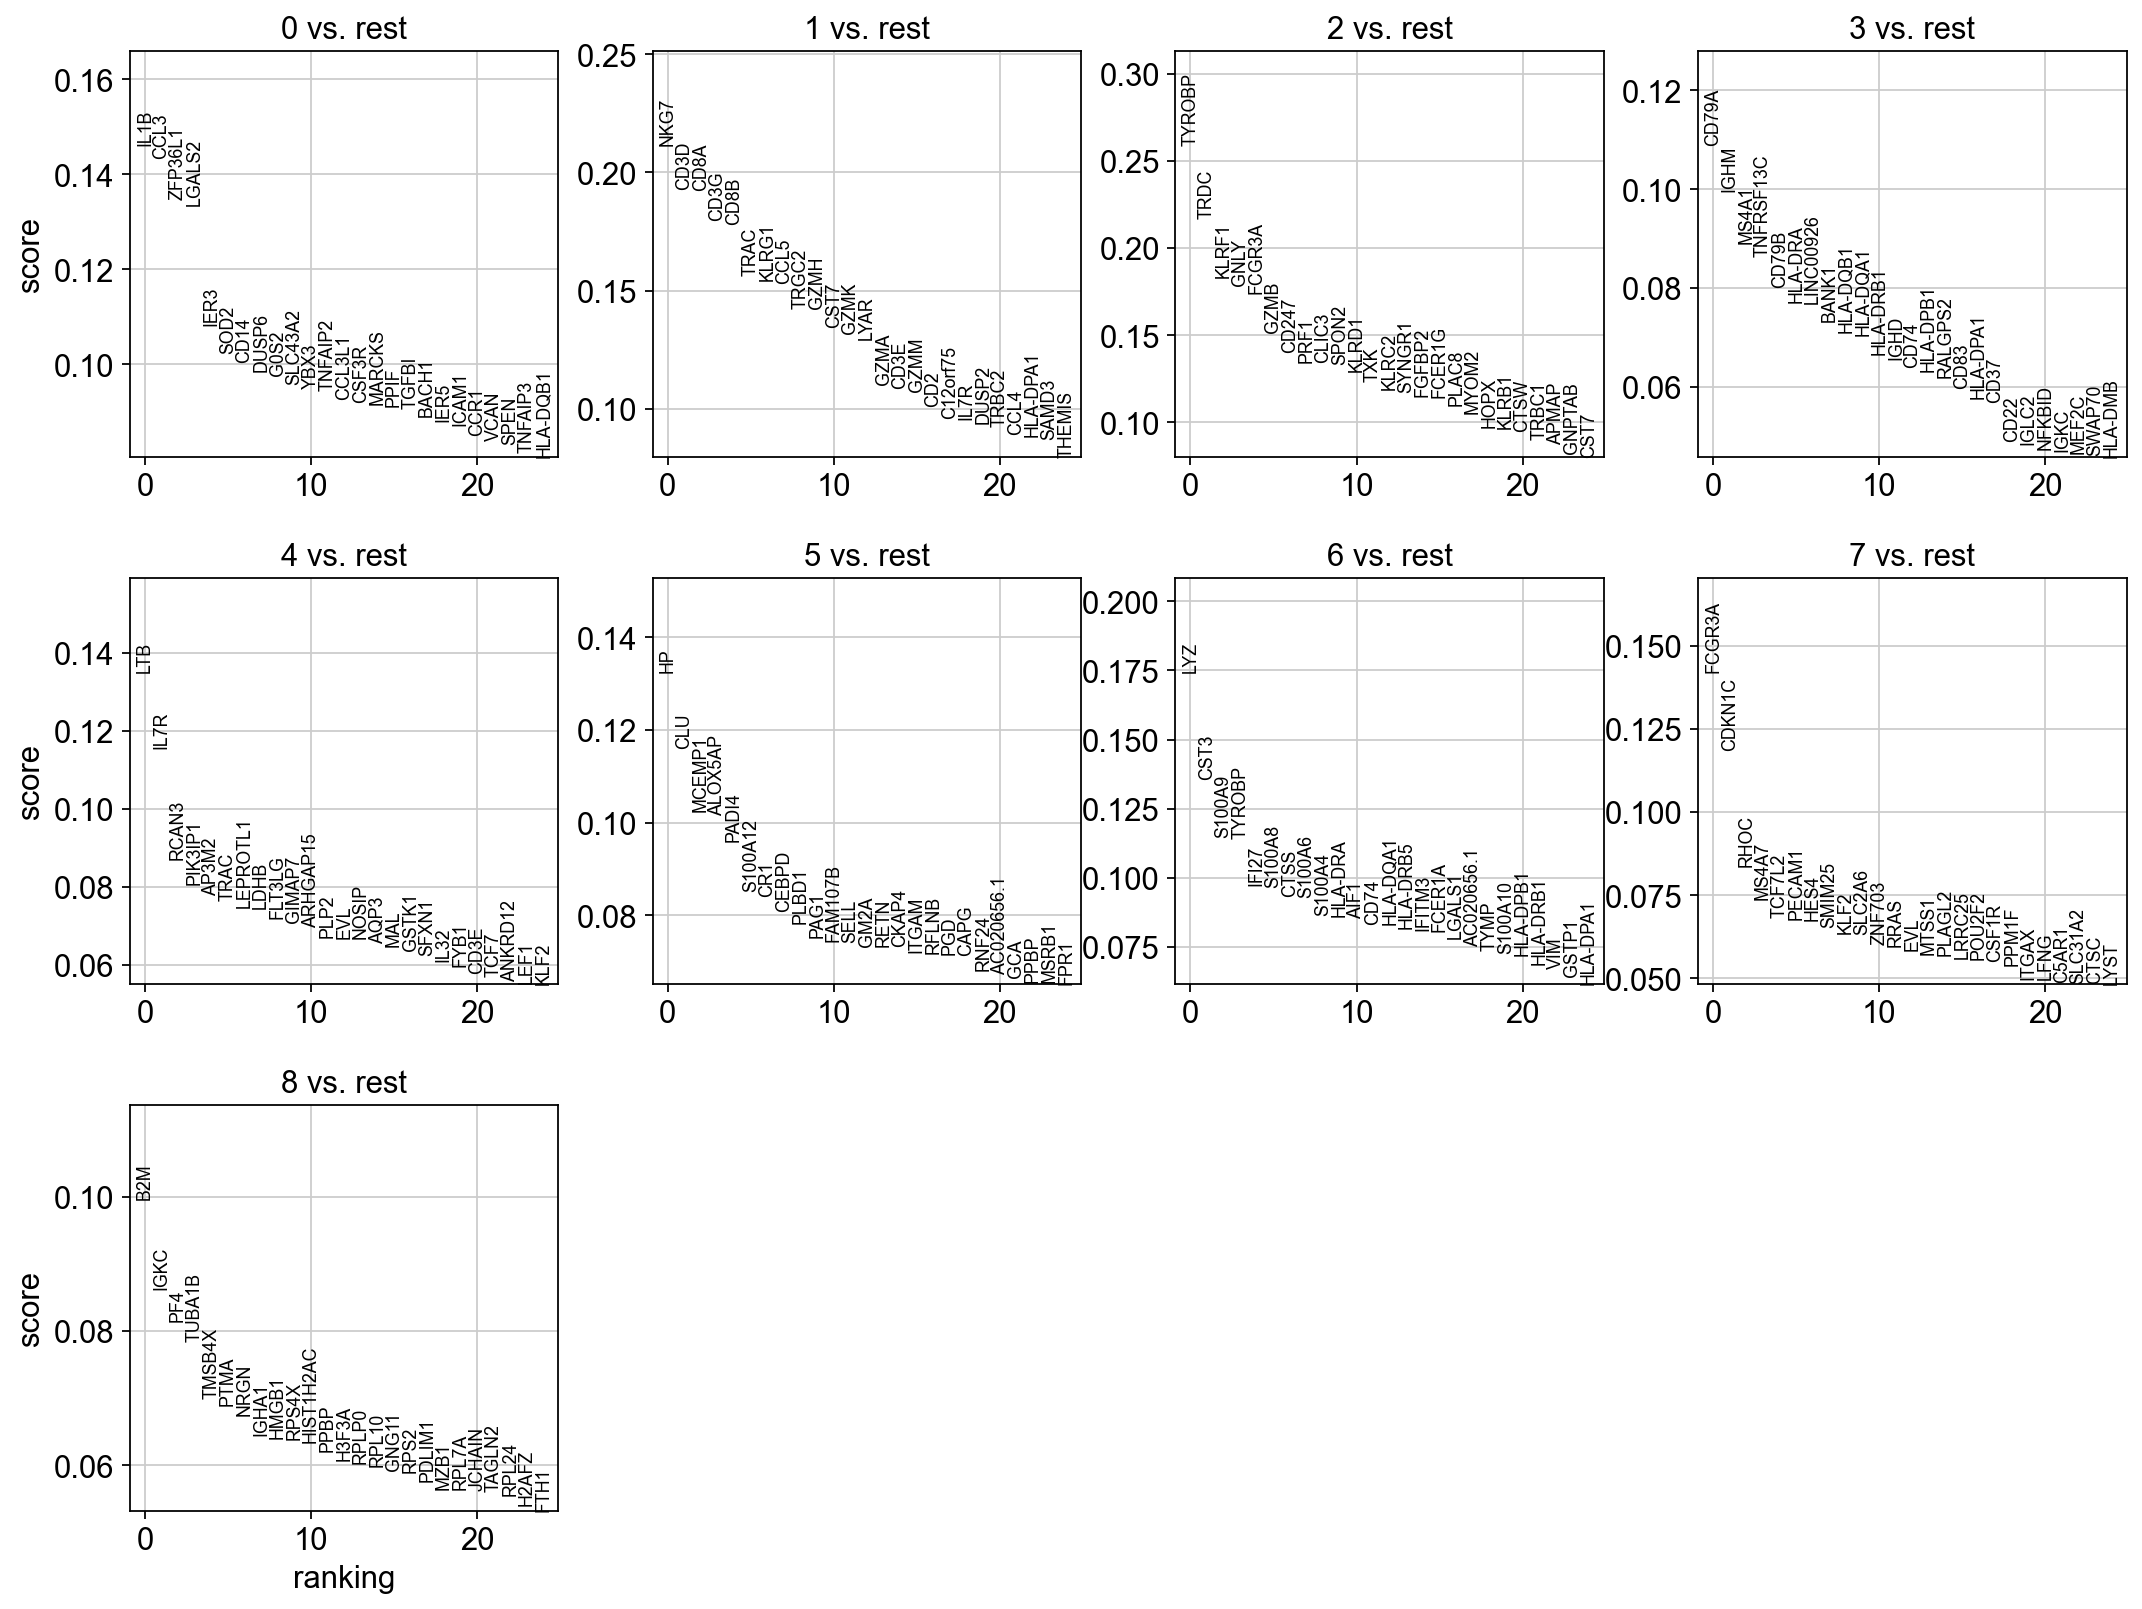

In [13]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

### 5. Compare genes

compare DE gnes for cluster 0 with each test 

In [15]:
wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

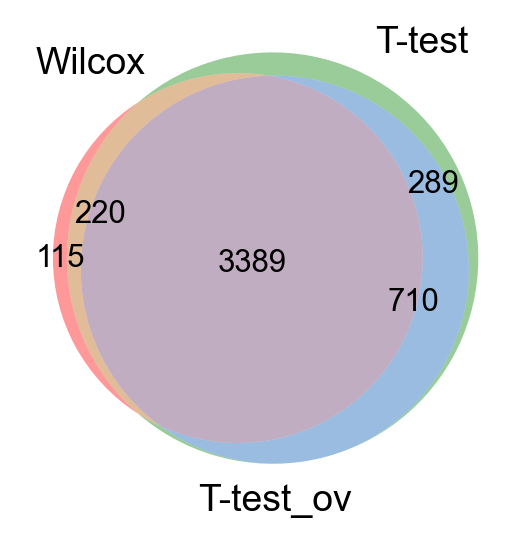

In [18]:
from matplotlib_venn import venn3
venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

### 6. Visualization

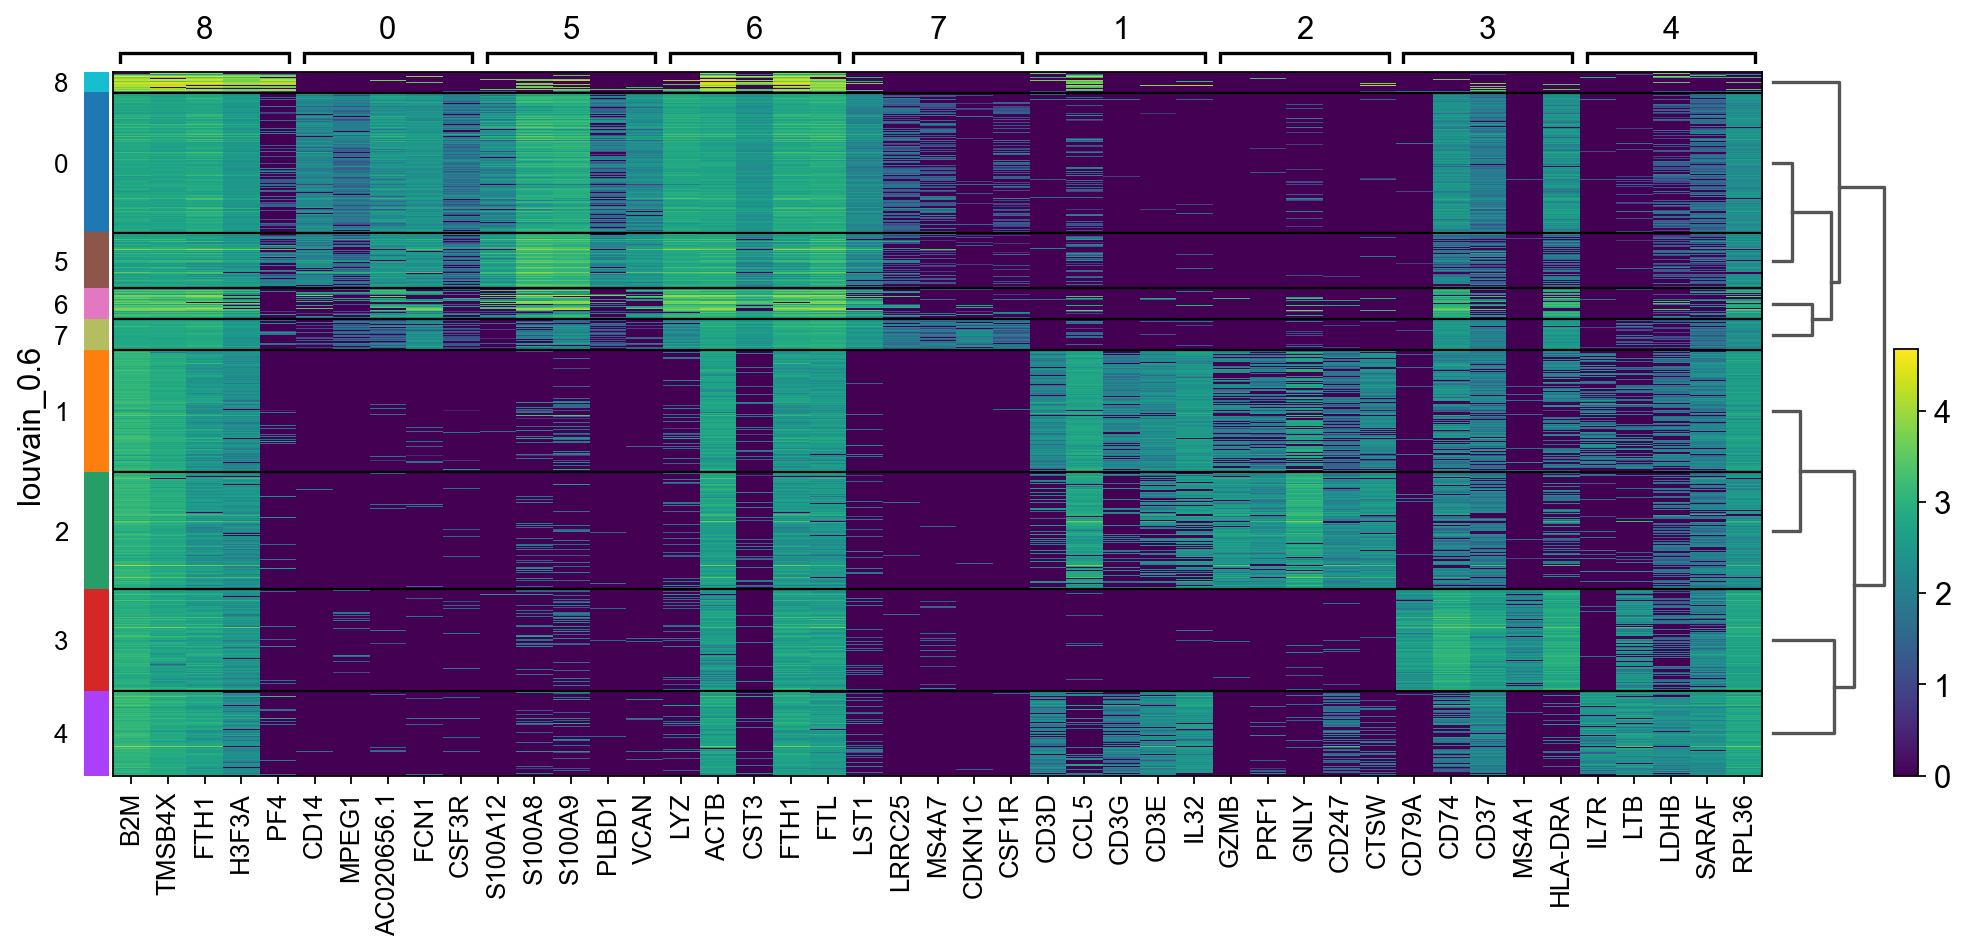

In [19]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6", show_gene_labels=True)


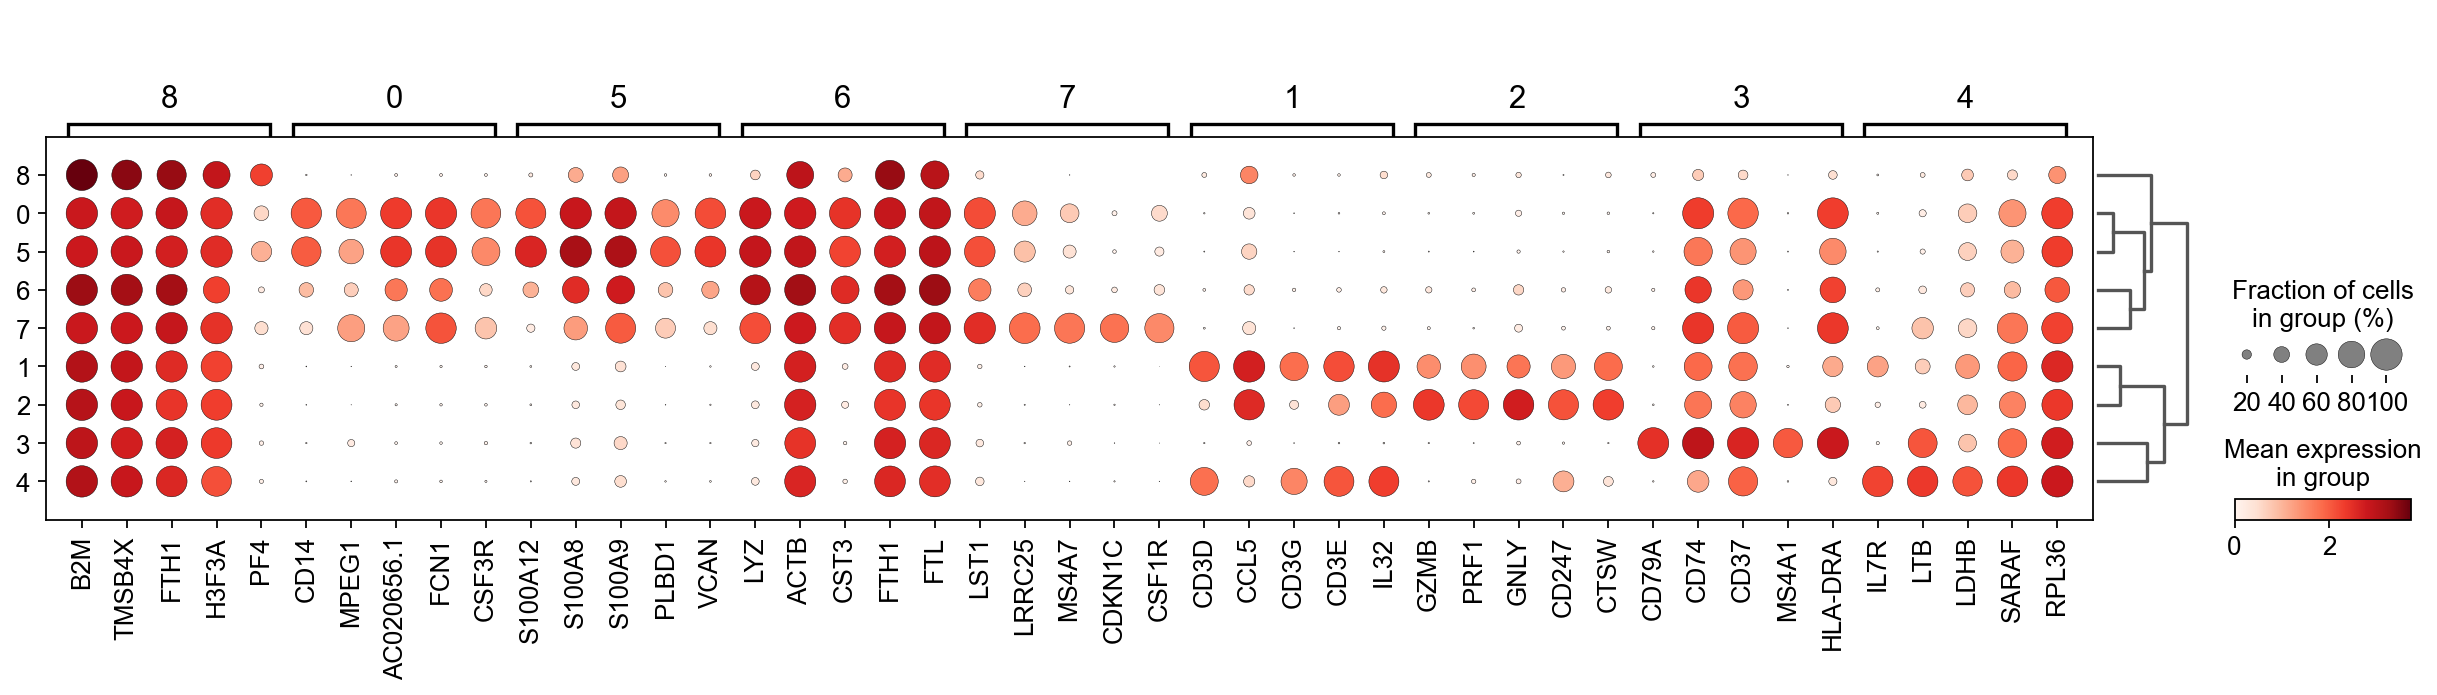

In [20]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

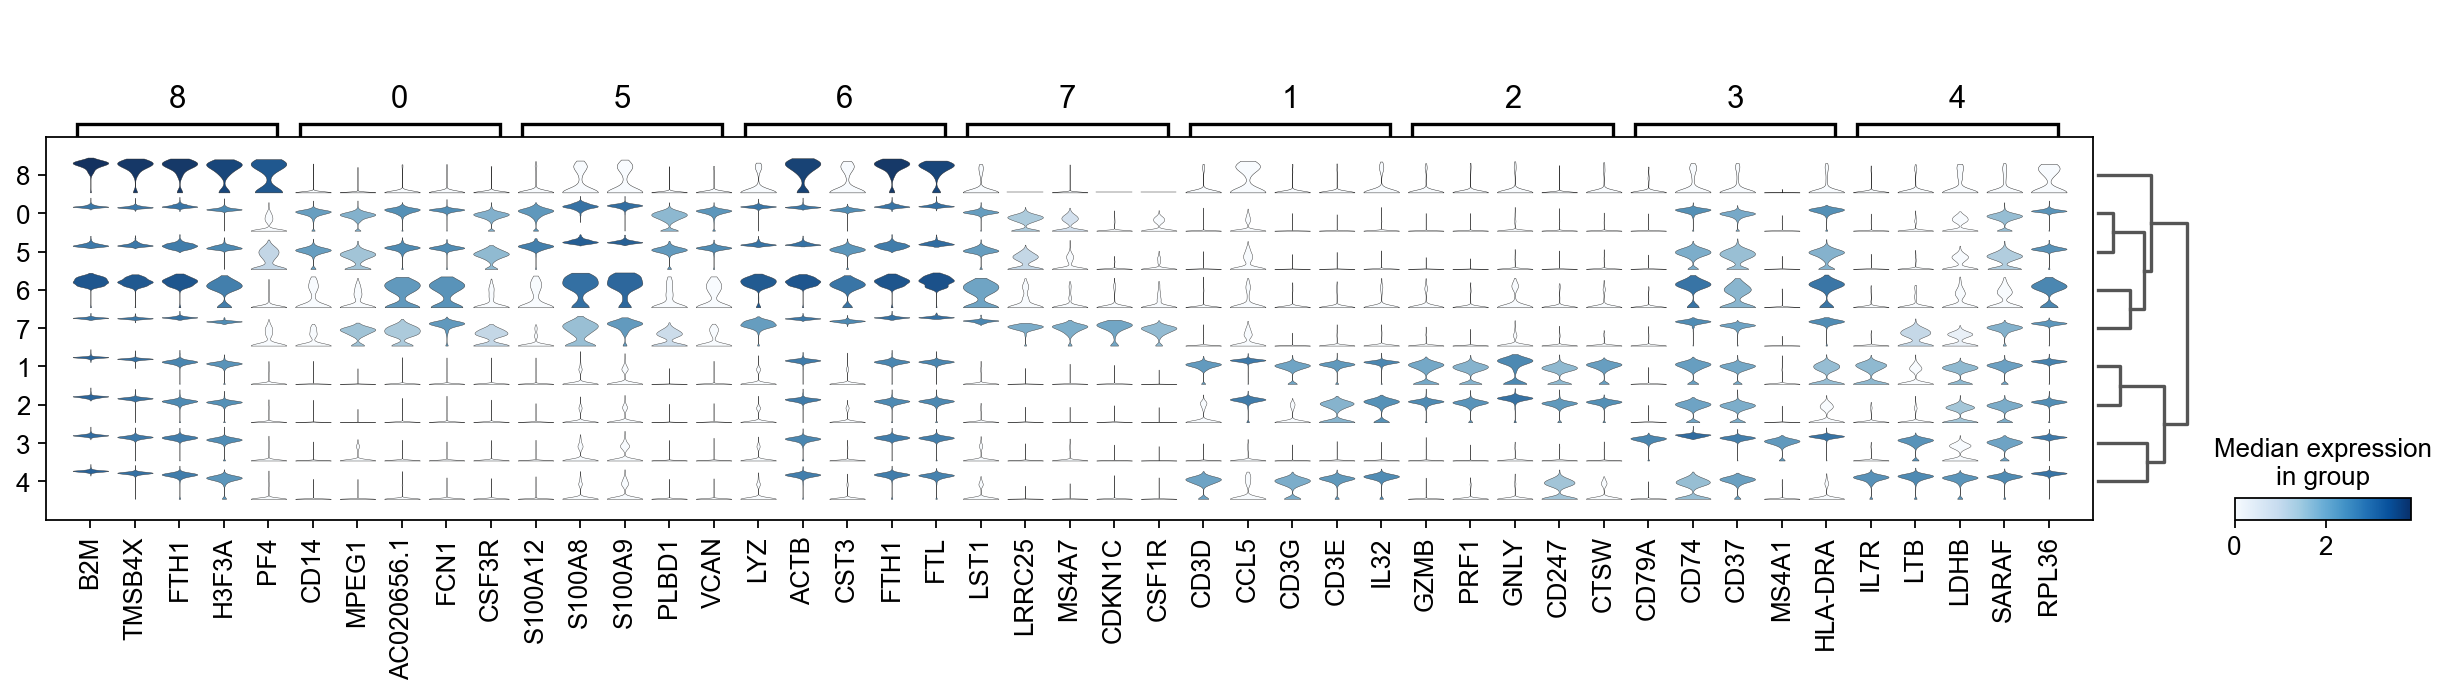

In [21]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

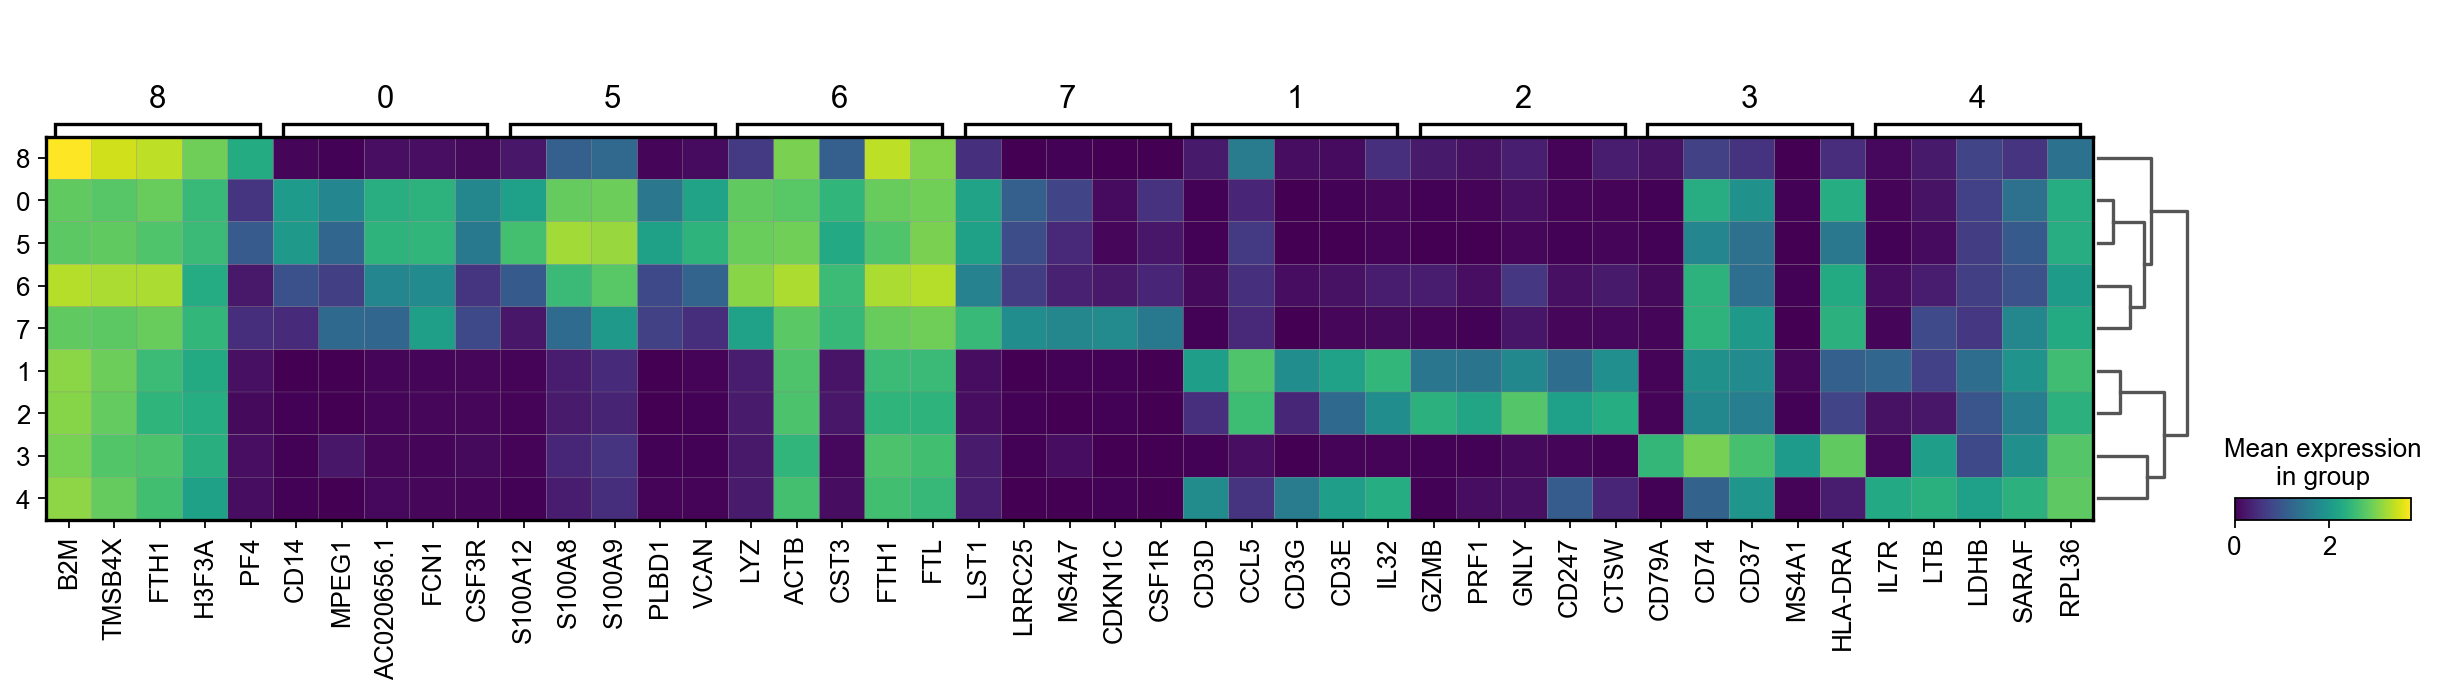

In [22]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain_0.6")

### 7. Compare specific clusters

ranking genes
    finished (0:00:07)


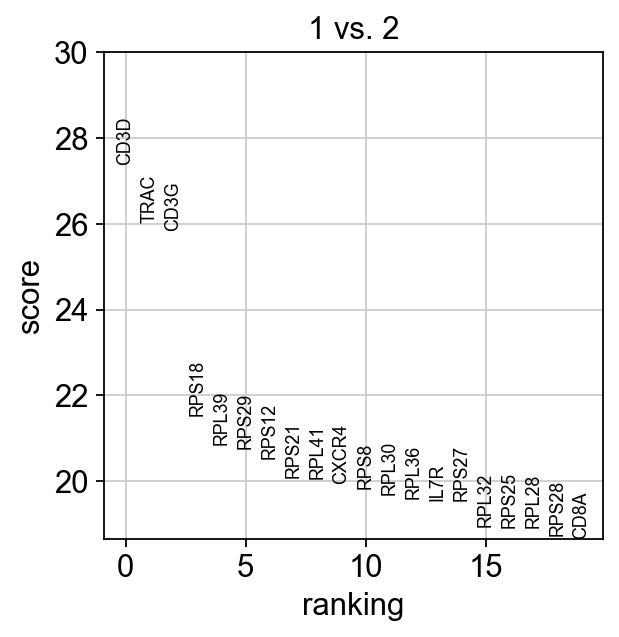

In [23]:
sc.tl.rank_genes_groups(adata, 'louvain_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

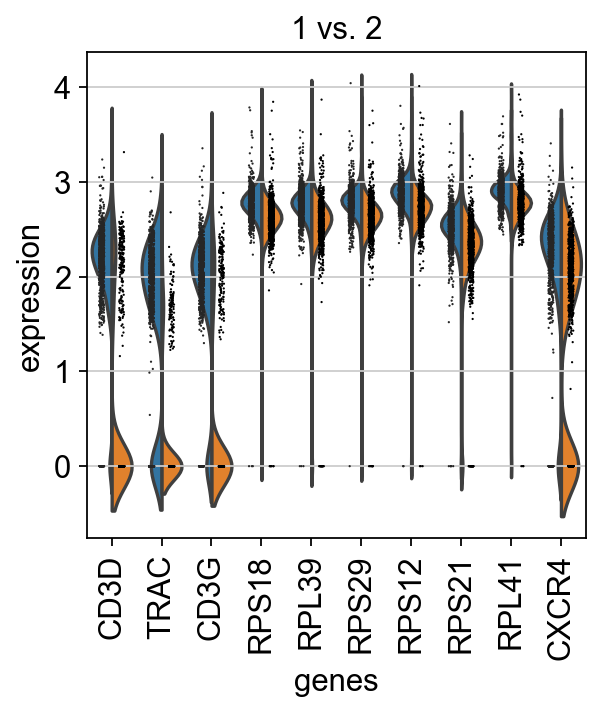

In [24]:
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

 plot the same genes as violins across all the datasets.

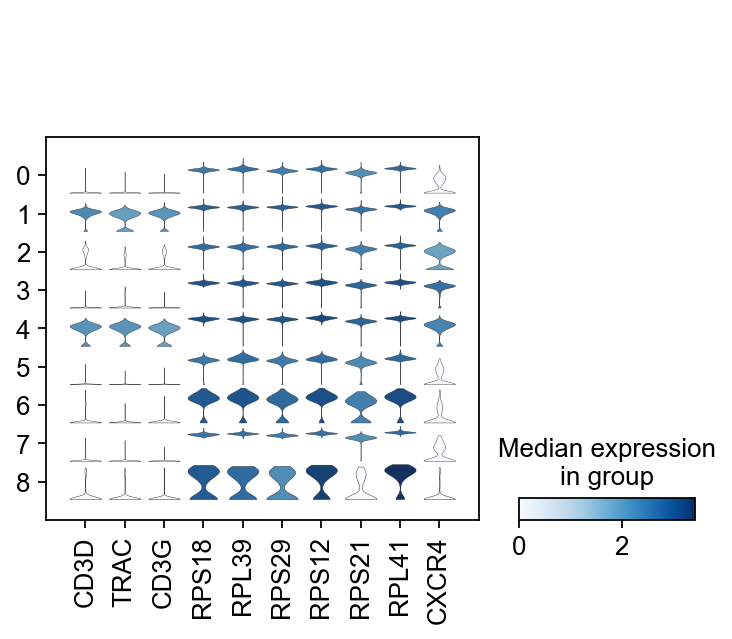

In [25]:


# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'louvain_0.6')

### Differential expression across conditions

In [26]:
cl1 = adata[adata.obs['louvain_0.6'] =='1',:]
cl1.obs['type'].value_counts()

Ctrl     661
Covid    303
Name: type, dtype: int64

ranking genes


C:\Users\Mujtaba Barci\anaconda3\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


    finished (0:00:05)


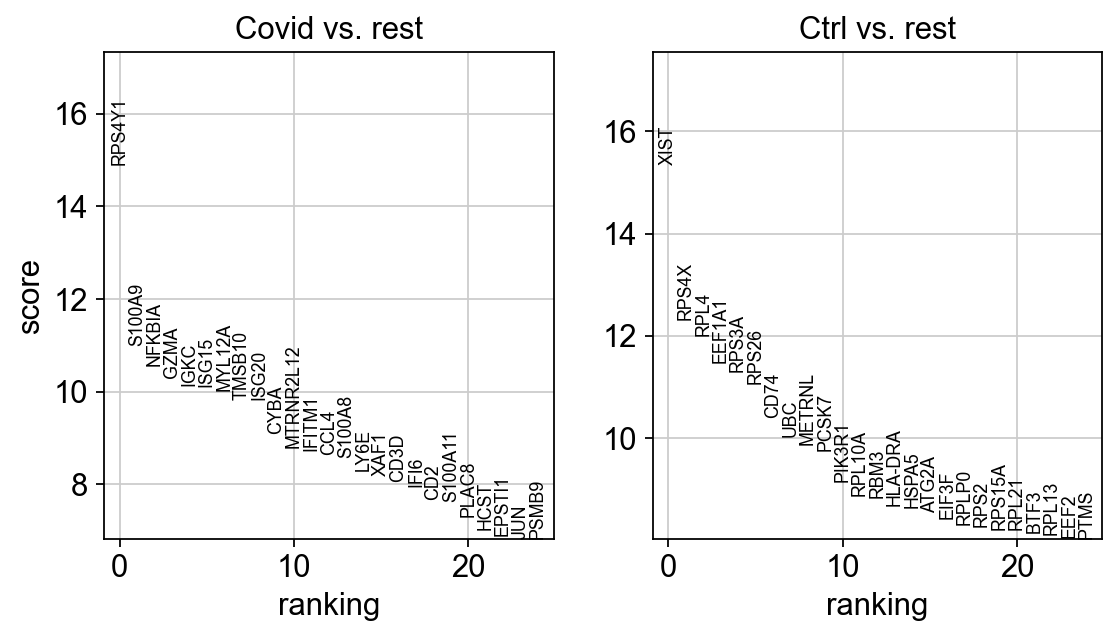

In [27]:
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key = "wilcoxon")

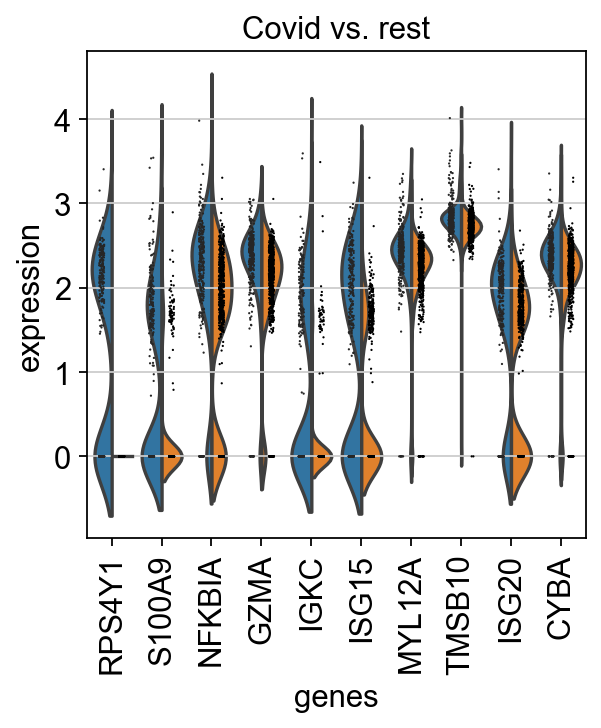

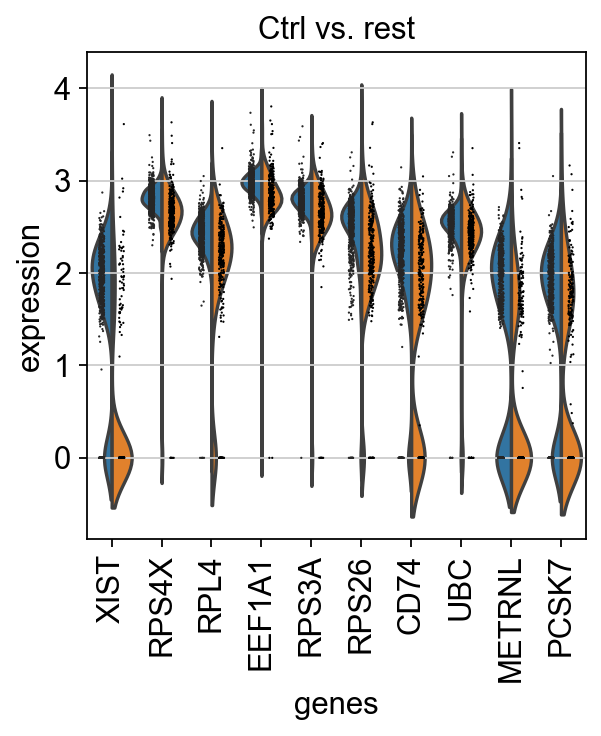

In [28]:
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")

In [30]:
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['louvain_0.6','type'], use_raw=False)
df2 = df.melt(id_vars=["louvain_0.6",'type'], value_vars=genes)